# Solving the Schrödinger equation by the split-step method

In this notebook we will learn how to

* compute the exponential of the Hamiltonian using functions of differentiation operators (`diffop`, `laplaciansymbol`,`laplacianopexp`), 
* compute its exponential (`torch.matrix_exp`),
* and apply it to a vector (`expsolve.linalg.matmul`).

*&#169; Copyright 2019-2023 Pranav Singh*

Use of this source code is governed by the MIT license that can be found in the LICENSE file.

In [24]:
import time 

import numpy as np

import matplotlib.pyplot as plt

import expsolve as es
import expsolve.discretize.tensorgrid as ex

import torch
from torch import exp, kron, eye, sin, cos, abs, real, imag, pi, max, diag
from torch.linalg import norm, matrix_exp

## The splitting approach for solving the Schrödinger equation

The splitting approach involves approximating the matrix exponential in 

$$ u(t) = \exp\left(-i t \mathbf{H}\right) u(0) $$

as 

$$ \exp\left(-i h\, \mathbf{H}\right) \quad = \quad \exp\left(i h\, \mathbf{D}_2 - i h\, \texttt{diag}(V) \right) \quad \approx \quad \exp\left(i h\, \mathbf{D}_2\right) \ \exp\left(- i h\, \texttt{diag}(V) \right) $$

which is the 1st order approximation called the Trotter splitting (and h is the time step) or as

$$ \exp\left(-i h\, \mathbf{H}\right) \quad = \quad \exp\left(i h\, \mathbf{D}_2 - i h\, \texttt{diag}(V) \right) \quad \approx \quad \exp\left(- i \frac{h}{2}\, \texttt{diag}(V) \right) \exp\left(i h\, \mathbf{D}_2\right) \ \exp\left(- i \frac{h}{2}\, \texttt{diag}(V) \right) $$

which is the 2nd order approximation called the Strang splitting.

The overall numerical scheme (in the case of the Strang splitting) is:

$$ u_{n+1} = \exp\left(- i \frac{h}{2}\, \texttt{diag}(V) \right) \exp\left(i h\, \mathbf{D}_2\right) \ \exp\left(- i \frac{h}{2}\, \texttt{diag}(V) \right) u_n $$

Splitting is useful because we can compute the exponentials of $\texttt{diag}(V)$ and $\mathbf{D}_2$ much more cheaply separately than we can compute the exponential when they are combined in the full discrestised $\mathbf{H}$. For instance, the computation of the exponential of $\mathbf{H}$ using `matrix_exp` costs $\mathcal{O}\left(n^3\right)$ operations. On the other hand, exponential of $\texttt{diag}(V)$ can be computed in a pointwise way in $\mathcal{O}(n)$ operations, while exponential of $\mathbf{D}_2$ costs us $\mathcal{O}(n \log n)$ operations using `diffopexp`:

```Python
    eDu = ex.diffopexp(j, k, c, u, xrange) 
```
which computes $\exp(c \mathbf{D}_{j,k}) u$, where `u` is the vector of values on a periodic grid defined on the domain `xrange`, $\mathbf{D}_{j,k}$ is the $k$ th differentiation operator in the $j$ th direction. 

* In 1D we only need $j=0$. 
* Since we need 2nd derivative, $k=2$. 

#### Grid & Initial Condition

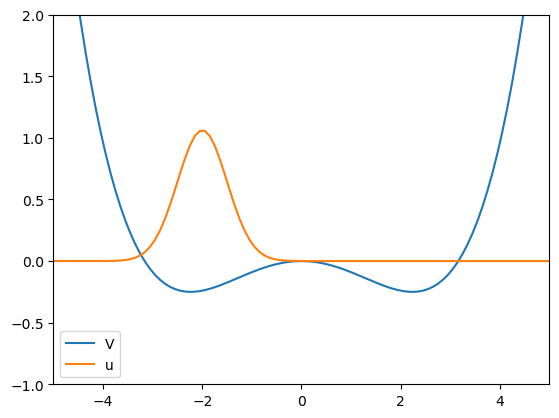

In [25]:
n = 200
L = 10
xr = [-L, L]
x = ex.grid1d(n, xr)

x0 = -2.0
u = exp(-(x-x0)**2/(2*0.25))
u = ex.normalize(u, xr)    

V = x**4 - 10*x**2

ex.plot(plt, x, V/100)
ex.plot(plt, x, real(u))
plt.xlim(-5,5)
plt.ylim(-1,2)
plt.legend(['V','u'])
plt.show()

### A single step of Strang

We create lambda functions for computing $\exp(i h D_2) u$ and $\exp(-i h \texttt{diag}(V)) u$, and compose them to form a single step of Strang:

$$\exp\left(- i \frac{h}{2}\, \texttt{diag}(V) \right) \exp\left(i h\, \mathbf{D}_2\right) \ \exp\left(- i \frac{h}{2}\, \texttt{diag}(V) \right) u_n $$

#### $\star$ `diffopexp`

In [26]:
eLu = lambda h, u: ex.diffopexp(0, 2, 1j*h, u, xr)
eVu = lambda h, u: exp(-1j*h*V)*u
strang = lambda h, u: eVu(h/2, eLu(h, eVu(h/2, u)))

Let's run a single step of Strang for time step $h=0.1$ and compare it to the `matrix_exp` solution (which is exact to machine precision):

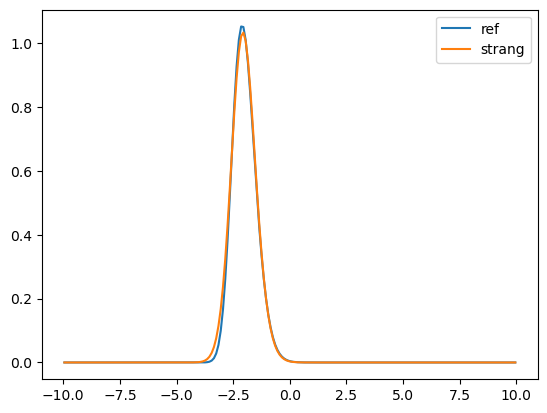

The L2 error in Strang splitting is tensor([0.0630], dtype=torch.float64)


In [27]:
D2 = ex.diffmatrix(2, n, xr)
H = -D2 + es.linalg.diag(V)
exact = lambda h, u: es.linalg.matmul(matrix_exp(-1j*h*H) , u)

h = 0.1

uref = exact(h, u)
ustrang = strang(h, u)

ex.plot(plt, x, abs(uref))
ex.plot(plt, x, abs(ustrang))
plt.legend(['ref','strang'])
plt.show()

print(f'The L2 error in Strang splitting is {ex.l2norm(uref-ustrang, xr)}')

#### Full run of Strang up to time T = 1

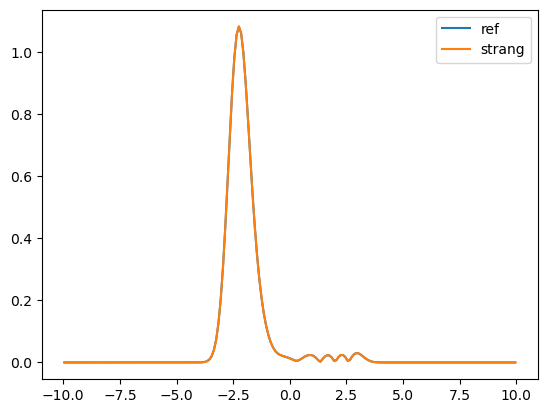

The L2 error in Strang splitting is tensor([1.6601e-05], dtype=torch.float64)


In [28]:
def runstrang(T, N, u0):
    u = u0
    h = T/N
    for i in range(N):
        u = strang(h, u)
    return u

T = 1

urefT = exact(T, u)
ustrangT = runstrang(T,1000,u)
ex.plot(plt, x, abs(urefT))
ex.plot(plt, x, abs(ustrangT))
plt.legend(['ref','strang'])
plt.show()

print(f'The L2 error in Strang splitting is {ex.l2norm(urefT-ustrangT, xr)}')

When we run Strang splitting with a small enough time step, it becomes pretty accurate

### Analysing order of Strang

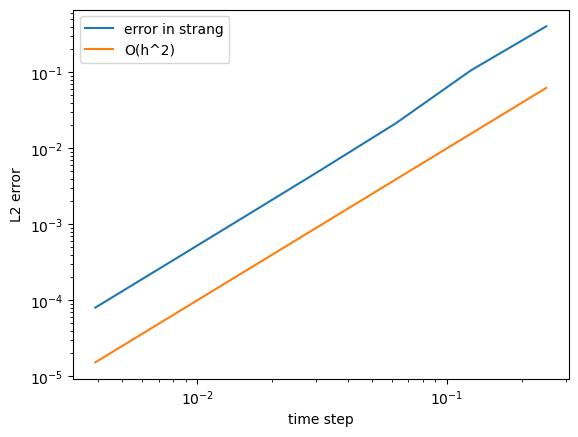

In [29]:
Nlist = 2**np.arange(2,9)
hlist = T/Nlist
err = [ex.l2norm(urefT-runstrang(T,N,u))[0] for N in Nlist]
plt.loglog(hlist, err)
plt.loglog(hlist, hlist**2)
plt.xlabel('time step')
plt.ylabel('L2 error')
plt.legend(['error in strang', 'O(h^2)'])
plt.show()

As we can see, the (global) error of Strang is $\mathcal{O}(h^2)$.

### A comparison of speed

When $n$ becomes large, `matrix_exp` is an extremely inefficient method since its cost scales as $\mathcal{O}\left(n^3\right)$. On the other hand, the cost of Strang scales as $\mathcal{O}\left(n \log n\right)$, which is significantly cheaper

In [30]:
n = 2000

L = 10
xr = [-L, L]
x = ex.grid1d(n, xr)

x0 = -2.0
u = exp(-(x-x0)**2/(2*0.25))
u = ex.normalize(u, xr)    


V = x**4 - 10*x**2

T = 1

tic_exact = time.perf_counter()
D2 = ex.diffmatrix(2, n, xr)
H = -D2 + es.linalg.diag(V)
urefT = es.linalg.matmul(matrix_exp(-1j*T*H) , u)
toc_exact = time.perf_counter()
print(f'matrix_exp took {toc_exact-tic_exact:0.4f} seconds')

tic_strang = time.perf_counter()
eLu = lambda h, u: ex.diffopexp(0, 2, 1j*h, u, xr)
eVu = lambda h, u: exp(-1j*h*V)*u
strang = lambda h, u: eVu(h/2, eLu(h, eVu(h/2, u)))
def runstrang(T, N, u0):
    u = u0
    h = T/N
    for i in range(N):
        u = strang(h, u)
    return u

ustrangT = runstrang(T, 1000, u)
toc_strang = time.perf_counter()


print(f'Strang took {toc_strang-tic_strang:0.4f} seconds')

print(f'The L2 error in Strang splitting is {ex.l2norm(urefT-ustrangT, xr)}')

matrix_exp took 9.3393 seconds
Strang took 0.6628 seconds
The L2 error in Strang splitting is tensor([1.6571e-05], dtype=torch.float64)


## Higher dimensions using `diffopexp`

In higher dimensions, the Hamiltonian is

$$ \mathrm{H} = -\Delta + V $$

where $\Delta = \sum_{j=1}^d \partial_{x_j}^2$ is the Laplacian. The Hamiltonian is discretized as 

$$ \mathbf{H} = -\mathbf{L} + \texttt{diag}(V), $$

where $\mathbf{L} = \sum_{j=1}^d \mathbf{D}_{j,2}$. The Strang splitting takes the form

$$\exp\left(- i \frac{h}{2}\, \texttt{diag}(V) \right) \exp\left(i h\, \mathbf{L}\right) \ \exp\left(- i \frac{h}{2}\, \texttt{diag}(V) \right) u_n $$

However, we can further compute the central exponential as 

$$\exp\left(i h\, \mathbf{L}\right) = \prod_{j=1}^d \exp\left(i h\, \mathbf{D}_{j,2}\right) $$

Since the differentiation operators and matrices commute, there is no error involve in the above step and the order of product is also not relevant. 

`diffopexp` provides a way to compute $\exp\left(i h\, \mathbf{D}_{j,2}\right)$ for each `j`, and this is simplest (although not the most efficient) way to get started with computing higher dimensional solutions.

### 2D example

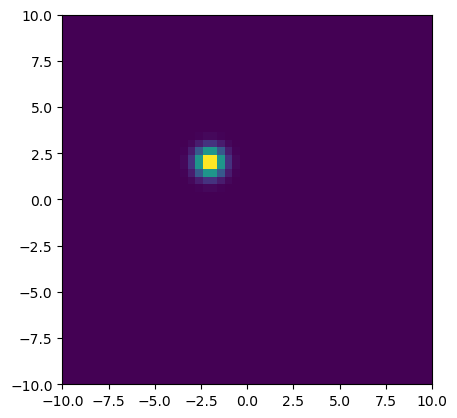

In [31]:
n = [50, 50]
xr = [-10, 10]
[x,y] = ex.grid(n, xr)

x0 = -2.0
y0 = -2.0
u = exp(-((x-x0)**2+(y-y0)**2)/(2*0.25))
u = ex.normalize(u, xr)     # normalize wavefunction and make it complex

ex.imshow(plt, xr, abs(u))
plt.show()

#### Potential

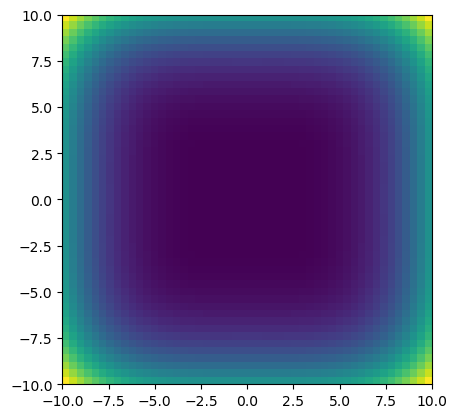

In [32]:
V = x**4 + y**4 - 5*x**2 - 5*y**2
ex.imshow(plt, xr, V)
plt.show()

#### The Strang splitting in 2D

In [40]:
eD1u = lambda h, u: ex.diffopexp(0, 2, 1j*h, u, xr) 
eD2u = lambda h, u: ex.diffopexp(1, 2, 1j*h, u, xr)
eLu = lambda h, u: eD1u(h, eD2u(h, u))

eVu = lambda h, u: exp(-1j*h*V)*u
strang = lambda h, u: eVu(h/2, eLu(h, eVu(h/2, u)))

#### A single step of Strang

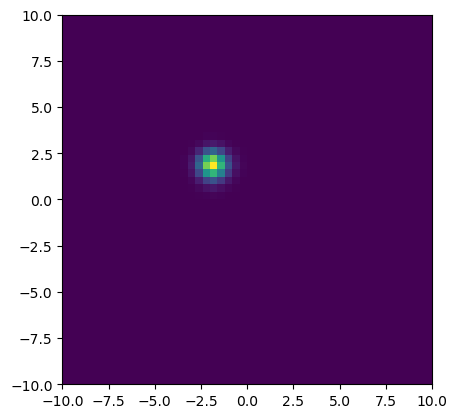

In [34]:
dt = 0.1

ustrang = strang(dt, u)

ex.imshow(plt, xr, abs(ustrang))
plt.show()

#### Full run of Strang

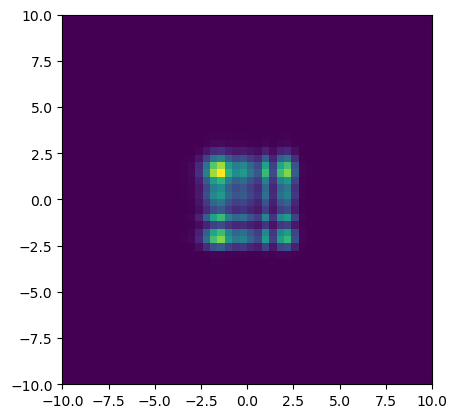

In [35]:
def runstrang(T, N, u0):
    u = u0
    h = T/N
    for i in range(N):
        u = strang(h, u)
    return u

T = 1

ustrangT = runstrang(T,1000,u)
ex.imshow(plt, xr, abs(ustrangT))
plt.show()

#### Convergence order

To verify convergence of Strang splitting, we compute the brute force solution as a reference solution first.

In [36]:
Ia = eye(n[0])
Ib = eye(n[1])
D2a = ex.diffmatrix(2, n[0], xr)
D2b = ex.diffmatrix(2, n[1], xr)
Lap = kron(D2a, Ib) + kron(Ia, D2b)

H = -Lap + es.linalg.diag(V)
expH = matrix_exp(-1j*T*H)
urefT = es.linalg.matmul(expH , u)

ex.l2norm(ustrangT-urefT, xr)

tensor([5.0808e-05], dtype=torch.float64)

Now we run Strang for different time steps, to check order of convergence

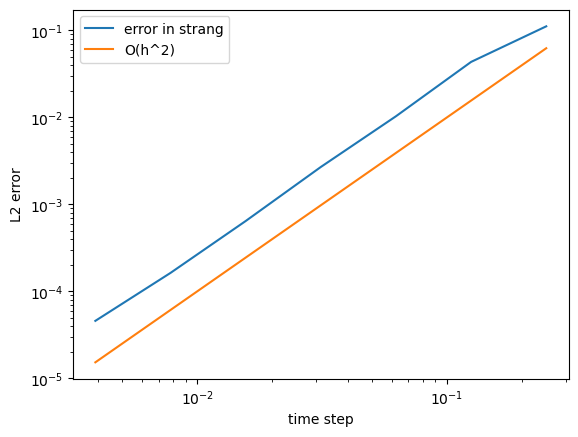

In [37]:
Nlist = 2**np.arange(2,9)
hlist = T/Nlist
err = [ex.l2norm(urefT-runstrang(T,N,u))[0] for N in Nlist]
plt.loglog(hlist, err)
plt.loglog(hlist, hlist**2)
plt.xlabel('time step')
plt.ylabel('L2 error')
plt.legend(['error in strang', 'O(h^2)'])
plt.show()

The order is 2, as expected.

## Higher dimensions using `laplaciansymbol` and `laplacianopexp`

A more efficient implementation involves computing the symbol of the Laplacian once and re-using it. This also involves a single n-dimensional fft, which may be more efficient.

#### $\star$ `laplaciansymbol` and `laplacianopexp`

Recall the syntax for creating the Laplacian symbol,

```Python
    lapsymb = ex.laplaciansymbol(symbolfn, n, xrange)
```
where the value of `symbolfn` should typically be `ex.fouriersymbol`, and the computation of $e^{s \Delta} f$ for a scalar $s$.

```Python
    expLf = ex.laplacianopexp(lapsymb, s, u):
```

In [46]:
SL = ex.laplaciansymbol(ex.fouriersymbol, n, xr)
eLu = lambda h, u: ex.laplacianopexp(SL, 1j*h, u)
strangL = lambda h, u: eVu(h/2, eLu(h, eVu(h/2, u)))

ex.l2norm(strangL(0.1, u)-strang(0.1,u), xr)

tensor([0.], dtype=torch.float64)

As you can see, this gives a completely equivalent way of implementing the Strang splitting. However, `SL` only needs to be computed once now!